# ICCV 19 Figures

This notebook puts together figures generated for our ICCV'19 submission.

In [59]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np
import pandas as pd
import scipy.sparse

import torch
import torch.nn as nn

from gumi.pruning.mask_utils import group_sort, run_mbm
from gumi.model_runner import utils
from gumi import model_utils

# Plotting
import matplotlib as mpl

import matplotlib.pyplot as plt
plt.ioff()
plt.rcParams.update({'font.size': 12})
CMAP = plt.cm.inferno

# Seaborn style
import seaborn as sns
sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Group Configuration

### ResNet-164 on CIFAR-100

In [66]:
df = pd.read_csv('./data/group_cfg/resnet164_cifar100.csv')
df

,# params,Remain,# ops,Train acc.,Test acc.,cost
0,1.61,95,481.59,99.75,77.22,3.00
1,1.50,88,473.07,99.74,76.97,4.36
2,1.41,83,455.90,99.60,76.90,6.79
3,1.30,76,444.37,99.53,76.56,8.92
4,1.21,71,430.67,98.98,75.98,10.81
5,1.11,65,417.76,98.96,75.99,14.01
6,1.01,59,404.98,97.90,75.87,16.38
7,0.91,54,390.89,96.97,75.50,19.60
8,0.80,47,375.62,95.35,75.01,23.00
9,0.70,41,363.76,93.36,74.45,26.41


In [67]:
df2 = pd.read_csv('./data/group_cfg/resnet164_cifar100_manual.csv')
df2

,Label,# params,Remain,# ops,Train acc.,Test acc.
0,G=2,0.91,54,257.45,98.25,76.34
1,G=4,0.49,29,133.94,93.05,72.85
2,G=8,0.26,15,72.14,79.50,65.79
3,G_M=64,1.19,70,403.93,97.54,75.40
4,G_M=32,0.70,41,291.43,91.39,73.98


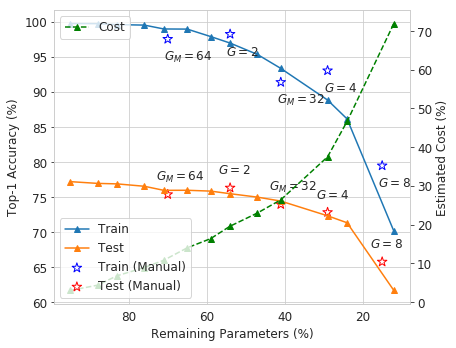

In [96]:
fig, ax = plt.subplots(figsize=(6.5, 5))

# draw the lines
ax.plot(df['Remain'], df['Train acc.'], label='Train', marker='^')
ax.plot(df['Remain'], df['Test acc.'], label='Test', marker='^')

# draw scatter points of manually explored models
ax.scatter(df2['Remain'], df2['Train acc.'],
           marker='*', s=100, facecolors='none', edgecolor='b', label='Train (Manual)')
ax.scatter(df2['Remain'], df2['Test acc.'],
           marker='*', s=100, facecolors='none', edgecolor='r', label='Test (Manual)')

for i, x in enumerate(df2['Remain']):
    ax.annotate('${}$'.format(df2.iloc[i]['Label']),
                (x + 1, df2.iloc[i]['Train acc.'] - 3))
    ax.annotate('${}$'.format(df2.iloc[i]['Label']),
                (x + 3, df2.iloc[i]['Test acc.'] + 2))

ax.set_xlabel('Remaining Parameters (%)')
ax.set_ylabel('Top-1 Accuracy (%)')
ax.invert_xaxis()
leg = ax.legend()
leg.remove()

ax2 = ax.twinx()
ax2.plot(df['Remain'], df['cost'], label='Cost', marker='^', color='g', linestyle='--')
ax2.set_ylabel('Estimated Cost (%)')
ax2.grid(False)
ax2.legend(loc=2)
ax2.add_artist(leg)

plt.tight_layout()
fig.savefig('./data/group_cfg/resnet164_cifar100.pdf')
plt.show()
plt.close()

### Structures of Explored Models

In [118]:
# load all the configuration files
import glob
import re
import json
from collections import OrderedDict

In [238]:
data = []

map_ = OrderedDict()
for fp in glob.glob('config/resnet164/cifar100/*.json'):
    max_npar = re.findall('\d\.\d', fp)[0]
    if max_npar == '0.6':
        continue
    with open(fp, 'r') as f:
        dat = json.load(f)
    
    id_to_G = OrderedDict()
    for key, val in dat.items():
        id_to_G[val['id']] = val['G']
    map_[max_npar] = id_to_G
    
# fix missing keys
ids = []
for val in map_.values():
    if len(val) > len(ids):
        ids = list(val.keys())

for key, val in map_.items():
    for id_ in ids:
        if id_ not in val:
            val[id_] = 1

map_ = OrderedDict(reversed(sorted(map_.items())))
            
cols = ['Max', 'ID', 'G']
for key, val in map_.items():
    key_ = int((float(key) / 1.7) * 100)
    print(key_)
    for i, (k, v) in enumerate(val.items()):
        data.append([str(key_) + '%', i + 1, v])
    
df = pd.DataFrame(data, columns=cols)
df.info()

94
88
82
76
70
64
58
52
47
41
29
23
17
11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 3 columns):
Max    1540 non-null object
ID     1540 non-null int64
G      1540 non-null int64
dtypes: int64(2), object(1)
memory usage: 36.2+ KB


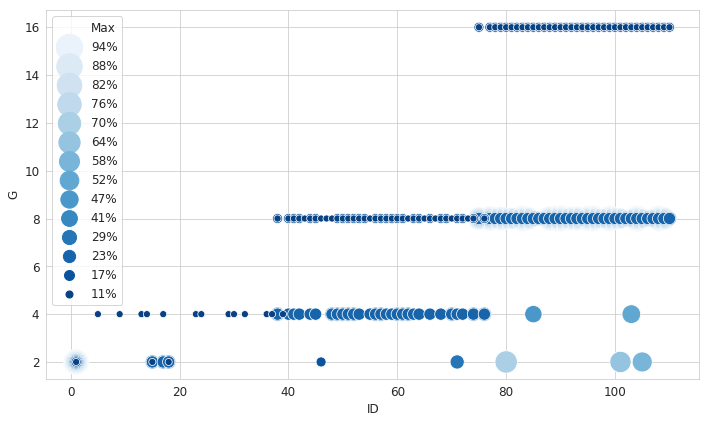

In [244]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

df_ = df[df['G'] > 1]

sns.scatterplot(x='ID', y='G', hue='Max',
                palette=sns.color_palette('Blues', n_colors=len(df_['Max'].unique())),
                size='Max',
                sizes=list(reversed((np.arange(1, len(df_['Max'].unique()) + 1) * 50).tolist())),
                # alpha=0.5,
                data=df_, ax=ax)

fig.savefig('data/gopt_result.pdf')
plt.tight_layout()
plt.show()
plt.close()

## Profiling

### Single Layer Profiling Result

In [99]:
df = pd.read_csv('./data/profile/resnet50.csv')

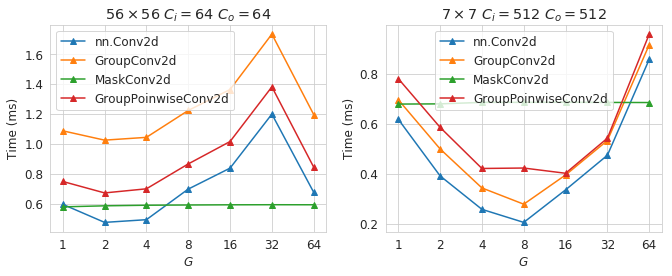

In [168]:
fig, axes = plt.subplots(figsize=(9.5, 4), ncols=2)

def plot_scale(scale, ax):
    mode_labels = {
        'conv': 'nn.Conv2d',
        'gconv': 'GroupConv2d',
        'mconv': 'MaskConv2d',
        'pwise': 'GroupPoinwiseConv2d'
    }
    df_ = df[df['Scale'] == scale]
    ticks = None
    for mode, label in mode_labels.items():
        tdf = df_[df_['Mode'] == mode]
        if ticks is None:
            ticks = tdf['G'].values.tolist()
        ax.plot(np.arange(1, len(ticks) + 1), tdf['Time'], marker='^', label=label)

    ax.legend()
    ax.set_xticklabels([0] + ticks)
    ax.set_xlabel('$G$')
    ax.set_ylabel('Time (ms)')
    ax.set_title(r'$%d \times %d\ C_i=%d\ C_o=%d$' % (scale, scale, df_['Channels'].iloc[0],  df_['Channels'].iloc[0]))
    
plot_scale(56, axes[0])
plot_scale(7, axes[1])

plt.tight_layout()
plt.show()
plt.close()

### Sparse Pointwise

In [175]:
df = pd.read_csv('./data/profile/sparse_pointwise_mobilenet_v1_new.csv')

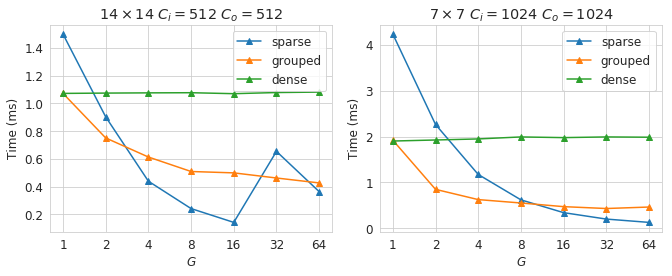

In [182]:
fig, axes = plt.subplots(figsize=(9.5, 4), ncols=2)

def plot_scale_sparse(scale, ax):
    mode_labels = {
        'sparse': 'sparse',
        'group': 'grouped',
        'dense': 'dense',
    }
    df_ = df[df['Scale'] == scale]
    ticks = None
    for mode, label in mode_labels.items():
        tdf = df_[df_['Mode'] == mode]
        if ticks is None:
            ticks = tdf['G'].values.tolist()
        ax.plot(np.arange(1, len(ticks) + 1), tdf['Time'], marker='^', label=label)

    ax.legend()
    ax.set_xticklabels([0] + ticks)
    ax.set_xlabel('$G$')
    ax.set_ylabel('Time (ms)')
    ax.set_title(r'$%d \times %d\ C_i=%d\ C_o=%d$' % (scale, scale, df_['Channels'].iloc[0],  df_['Channels'].iloc[0]))
    
plot_scale_sparse(14, axes[0])
plot_scale_sparse(7, axes[1])

plt.tight_layout()
plt.show()
plt.close()

## Performance of the Heuristic Algorithm

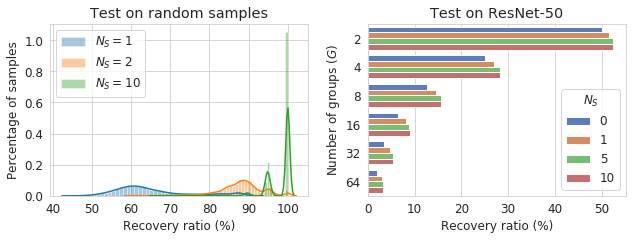

In [233]:
nis = (1, 2, 10)
df = pd.read_csv('./data/model_stats/model_stats_resnet50_NI_0-1-5-10_G_2-4-8-16-32-64.csv')

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.5))

# axes[0]
for ni in nis:
    y = np.load('./data/S_128_G_16/random_stats_NI_{}_NS_10000.npy'.format(ni))
    y *= 100
    sns.distplot(y, label=r'$N_S={}$'.format(ni), ax=axes[0])

axes[0].legend()
axes[0].set_title('Test on random samples')
axes[0].set_ylabel('Percentage of samples')
axes[0].set_xlabel('Recovery ratio (%)')

# axes[1]
sns.barplot(x='ratio', y='num_groups', hue='$N_S$', palette='muted',
            orient='h',
            data=df, ax=axes[1])
axes[1].set_title('Test on ResNet-50')
axes[1].set_ylabel(r'Number of groups ($G$)')
axes[1].set_xlabel('Recovery ratio (%)')

plt.tight_layout()
fig.savefig('./data/model_stats.pdf')
plt.show()
plt.close()

## Sparsity Pattern

### Plot the variance of NNZ across all layers

In [234]:
sparse_model = torch.load('/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/sparse/resnet18.pth.tar')

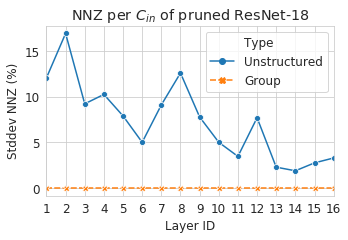

In [410]:
data = []
columns = ['Layer ID', 'Mean NNZ (%)', 'Stddev NNZ (%)', 'Type']
threshold = 1e-6

fig, ax = plt.subplots(figsize=(5, 3.5))

i = 1
for key, W in sparse_model['state_dict'].items():
    if 'conv' in key and 'layer' in key:
        W_ = W.norm(dim=(2, 3)).cpu().numpy()
        nnz_ = (W_ > 1e-6).sum(axis=1) / W_.shape[1] * 100
        mean_ = nnz_.mean()
        var_ = nnz_.std()
        data.append([i, mean_, var_, 'Unstructured'])
        data.append([i, 50.0, 0.0, 'Group'])

        i += 1
        
        
df = pd.DataFrame(data, columns=columns)

# sns.barplot(x='Layer ID', y='Mean NNZ (%)', hue='Type', palette='deep', data=df, ax=ax)
sns.lineplot(x='Layer ID', y='Stddev NNZ (%)', hue='Type', style='Type', data=df, markers=True, ax=ax)
ax.set_title(r'NNZ per $C_{in}$ of pruned ResNet-18')
ax.set_xlim([1, len(df)//2])
ax.set_xticks(np.arange(1, len(df) // 2 + 1))

plt.tight_layout()
fig.savefig('./data/nnz.pdf')
plt.show()
plt.close()

### Sparse Matrix Deployment

In [2]:
gmodel = torch.load(os.path.expandvars(
'$ICCV19/final/resnet18/imagenet/prune/G_8/GRPS_NS_10/LR_1e-3_N_30_S_10-20/model_best.pth.tar'))

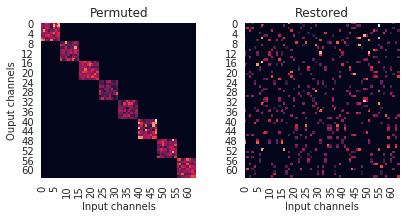

In [29]:
W = gmodel['state_dict']['module.layer1.1.conv2.weight']
W_ = W.norm(dim=(2, 3)).detach().cpu().numpy()

weight = gmodel['state_dict']['module.layer1.1.conv2.weight'].detach().cpu().numpy()
mask = gmodel['state_dict']['module.layer1.1.conv2.mask'].detach().cpu().numpy()

wg, ind_in, ind_out = model_utils.get_group_param(weight, mask, 8)

def rev_ind(ind):
    ind_ = [0] * len(ind)
    for i, j in enumerate(ind):
        ind_[j] = i
    return ind_

fig, axes = plt.subplots(ncols=2, figsize=(6, 3))

axes[0].set_title('Permuted')
sns.heatmap(W_[rev_ind(ind_out), :][:, ind_in], ax=axes[0],
            cbar=False, rasterized=True, square=True)
axes[0].set_ylabel('Ouput channels')
axes[0].set_xlabel('Input channels')


axes[1].set_title('Restored')
sns.heatmap(W_, ax=axes[1],
            cbar=False, rasterized=True, square=True)
axes[1].set_xlabel('Input channels')
 

plt.tight_layout()
fig.savefig('./data/sparse_pattern.pdf')
plt.show()
plt.close()

### NNZ of sparse MobileNet

In [245]:
checkpoint = torch.load(os.path.expandvars('$ICCV19/sparse/mobilenet_distiller/model_best.pth.tar'))
state_dict = checkpoint['state_dict']

In [274]:
data = []
cols = ['Layer', 'Output Channel', 'NNZ']

for i in range(4):
    key = 'module.layer4.{}.p_conv.weight'.format(i)
    W = state_dict[key]
    W_ = W.detach().cpu().numpy()
    W_ = W_.reshape((W_.shape[0], W_.shape[1]))

    nnz = (np.abs(W_) > 1e-8).sum(axis=1)
    
    for row, nnz_ in enumerate(nnz.tolist()):
        data.append([key, row, nnz_])
        
df = pd.DataFrame(data, columns=cols)

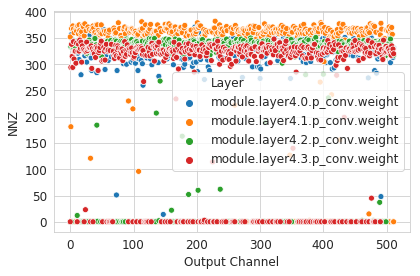

In [275]:
fig, ax = plt.subplots()

sns.scatterplot(x='Output Channel', y='NNZ', hue='Layer', palette=sns.color_palette(n_colors=4), data=df, ax=ax)

plt.tight_layout()
fig.savefig('data/mobilenet_sparse.pdf')
plt.show()
plt.close()

In [ ]:
data = []
columns = ['Layer ID', 'std', 'max', 'min', 'coo_time', 'csr_time', 'csr_time_blk', 'bsr_time_blk']
iters = 100
vec_len = 100

for i, (key, val) in enumerate(state_dict.items()):
    if 'p_conv' in key:
        W = val.detach().cpu().numpy()
        W = W.reshape(W.shape[0], W.shape[1])
        nz = (np.abs(W) < 1e-5).sum(axis=1)
        nnz = (1 - nz / W.shape[1]) * 100
        
        x = np.random.rand(W.shape[1], vec_len).astype(np.float32)
        W_coo = scipy.sparse.coo_matrix(W)
        W_csr = scipy.sparse.csr_matrix(W)
        
        print('==> Running COO test ...')
        start = time.time()
        for _ in range(iters):
            np.dot(W_coo, x)
        end = time.time()
        coo_time = (end - start) / iters
        
        print('==> Running CSR test ...')
        start = time.time()
        for _ in range(iters):
            np.dot(W_csr, x)
        end = time.time()
        csr_time = (end - start) / iters
        
        print('==> Generate block matrix ...')
        W_blk = np.zeros((W.shape[0], W.shape[1])).astype(np.float32)
        F, C = W.shape
        W_blk[:F//2, :C//2] = np.random.rand(F//2, C//2).astype(np.float32)
        W_blk[F//2:, C//2:] = np.random.rand(F//2, C//2).astype(np.float32)
        W_blk = W_blk[np.random.permutation(F), :][:, np.random.permutation(C)]
        
        W_blk_csr = scipy.sparse.csr_matrix(W_blk)
        W_blk_bsr = scipy.sparse.bsr_matrix(W_blk)
        
        print('==> Running CSR test ...')
        start = time.time()
        for _ in range(iters):
            np.dot(W_blk_csr, x)
        end = time.time()
        blk_csr_time = (end - start) / iters
        
        print('==> Running BSR test ...')
        start = time.time()
        for _ in range(iters):
            np.dot(W_blk_bsr, x)
        end = time.time()
        blk_bsr_time = (end - start) / iters
        
        res = [i, nnz.std(), nnz.max(), nnz.min(), coo_time, csr_time, blk_csr_time, blk_bsr_time]
        print(res)
        data.append(res)
        
df = pd.DataFrame(data, columns=columns)
df

==> Running COO test ...
==> Running CSR test ...
==> Generate block matrix ...
==> Running CSR test ...
==> Running BSR test ...
[12, 17.574259014978047, 46.875, 0.0, 0.3004900860786438, 0.21072149753570557, 0.20699271202087402, 0.21983424425125123]
==> Running COO test ...
==> Running CSR test ...
==> Generate block matrix ...
==> Running CSR test ...
==> Running BSR test ...
[24, 24.100646336978023, 82.8125, 0.0, 1.1005030059814453, 0.756035349369049, 0.5847237634658814, 0.6086728405952454]
==> Running COO test ...
==> Running CSR test ...
==> Generate block matrix ...
==> Running CSR test ...
==> Running BSR test ...
[36, 27.373667426531526, 91.40625, 0.0, 3.8819724702835083, 2.142044904232025, 1.4970939683914184, 1.5348145246505738]
==> Running COO test ...
==> Running CSR test ...
==> Generate block matrix ...
==> Running CSR test ...
==> Running BSR test ...
[48, 20.582546121264599, 75.0, 0.0, 3.7747615146636964, 2.1625349497795106, 2.3448160886764526, 2.3917877888679504]
==> Ru

In [276]:
import scipy.optimize

In [289]:
N = 1
H = 7
W = 7
L = int(N * H * W)

X = np.zeros(H * W * H * W)
Y = np.random.random((N, H * W)).astype('float32')
Y_ = np.random.random((N, H * W)).astype('float32')

f = lambda X: ((Y - np.dot(Y_, X.reshape(H * W, H * W))) ** 2).sum()

In [290]:
%%timeit -n 1
scipy.optimize.minimize(f, X)

1.35 s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plot training curves

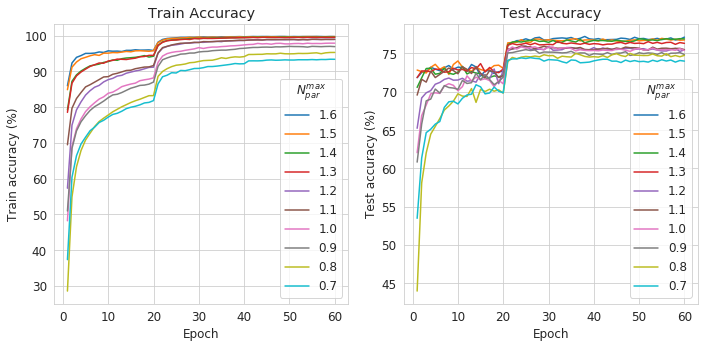

In [336]:
max_num_pars = [
    '1.6',
    '1.5',
    '1.4',
    '1.3',
    '1.2',
    '1.1',
    '1.0',
    '0.9',
    '0.8',
    '0.7',
]

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
for mp in max_num_pars:
    fp = os.path.expandvars(
        '$ICCV19/search/preresnet164/cifar100/prune/CFG_MP-{}-MIN-8/GRPS_NS_10/LR_5e-3_N_60_S_20-40/log.txt'.format(mp))
    df = pd.read_csv(fp, sep='\t', usecols=['Train Acc.', 'Valid Acc.'])
    
    axes[0].plot(np.arange(1, len(df)+1), df['Train Acc.'], label=mp)
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Train Accuracy')
    axes[0].set_ylabel('Train accuracy (%)')
    axes[0].legend(title='$N_{par}^{max}$')
    
    axes[1].plot(np.arange(1, len(df)+1), df['Valid Acc.'], label=mp)
    axes[1].set_title('Test Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Test accuracy (%)')
    axes[1].legend(title='$N_{par}^{max}$')

plt.tight_layout()
fig.savefig('./data/gopt_curves.pdf')
plt.show()
plt.close()

### Comparing training from scratch and pruning

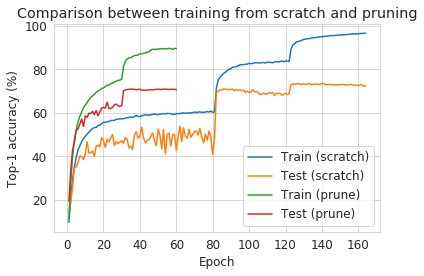

In [345]:
label_to_file = {
    'scratch': '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/ablation_scratch/preresnet164/cifar100/scratch/G_4/shuffle/LR_0.1_N_164_S_81-122/log.txt',
    'prune': '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/final/preresnet164/cifar100/prune/G_4/GRPS_NS_10/LR_0.01_N_60_S_30-45/log.txt'
}

fig, ax = plt.subplots()
for label, fp in label_to_file.items():
    df = pd.read_csv(fp, sep='\t', usecols=['Train Acc.', 'Valid Acc.'])
    
    ax.set_title('Comparison between training from scratch and pruning')
    
    ax.plot(np.arange(1, len(df)+1), df['Train Acc.'], label='Train ({})'.format(label))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Train accuracy (%)')
    
    ax.plot(np.arange(1, len(df)+1), df['Valid Acc.'], label='Test ({})'.format(label))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Top-1 accuracy (%)')
    ax.legend()

plt.tight_layout()
fig.savefig('./data/ablation_curves.pdf')
plt.show()
plt.close()

### ImageNet training result

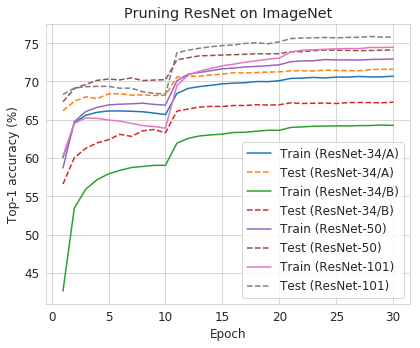

In [358]:
label_to_file = {
    'ResNet-34/A': '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/imagenet/resnet34_A_GRPS_LR_1e-3_30-10-20_NEW/log.txt',
    'ResNet-34/B': '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/imagenet/resnet34_B_GRPS_LR_1e-3_30-10-20_NEW/log.txt',
    'ResNet-50': '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/imagenet/resnet50_GRPS_LR_1e-3_30-10-20/log.txt',
    'ResNet-101': '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/imagenet/resnet101_GRPS_LR_1e-3_30-10-20/log.txt',
}

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Pruning ResNet on ImageNet')

for label, fp in label_to_file.items():
    df = pd.read_csv(fp, sep='\t', usecols=['Train Acc.', 'Valid Acc.'])
    
    ax.plot(np.arange(1, len(df)+1), df['Train Acc.'], label='Train ({})'.format(label))    
    ax.plot(np.arange(1, len(df)+1), df['Valid Acc.'], label='Test ({})'.format(label),
            linestyle='--')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Top-1 accuracy (%)')
    ax.legend()

plt.tight_layout()
fig.savefig('./data/imagenet_curves.pdf')
plt.show()
plt.close()